In [5]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset Exploration

Shape of MNIST images: (10000, 28, 28)


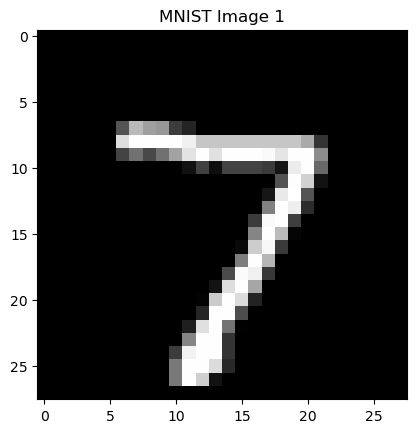

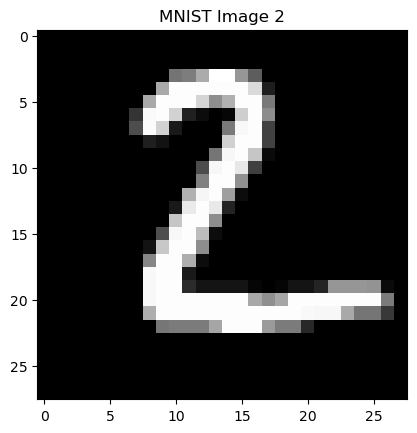

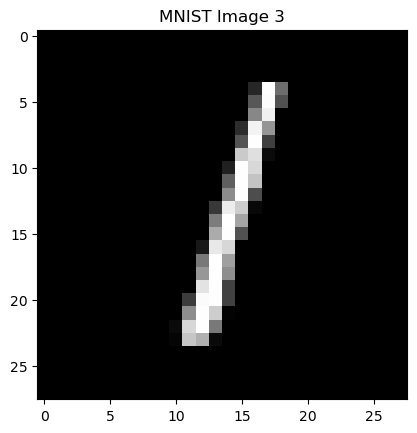

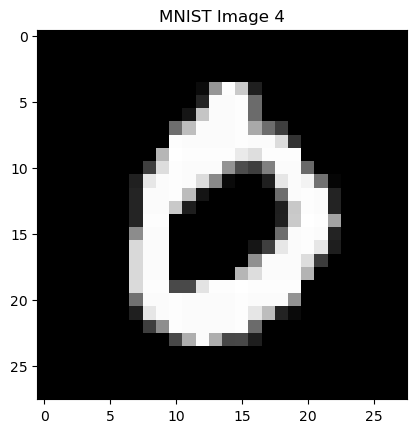

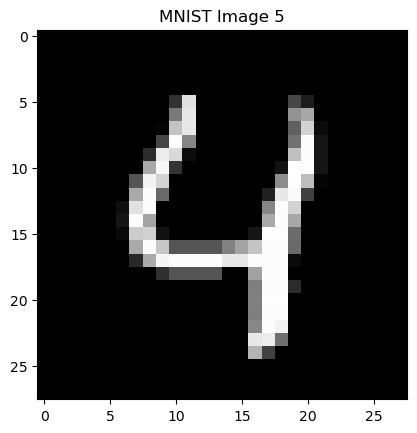

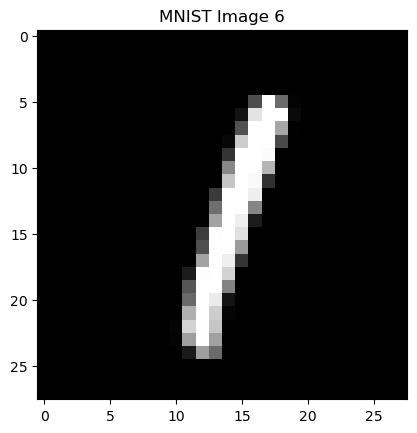

In [7]:
# make a function to get the MNIST data from a file and return it as a numpy array
def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        # Read magic number, number of images, rows, and columns
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read image data
        image_size = rows * cols
        images = np.frombuffer(f.read(image_size * num_images), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

    return images

# Provide the path to your MNIST dataset file
file_path = './datasets/10k_images.dat'

# Read MNIST images from the fileread_mnist_images(file_path)
mnist_images = read_mnist_images(file_path)
# Print the shape of the data
print(f'Shape of MNIST images: {mnist_images.shape}')

# Display the first few images
num_images_to_display = 6
for i in range(num_images_to_display):
    plt.imshow(mnist_images[i], cmap='gray')
    plt.title(f'MNIST Image {i + 1}')
    plt.show()

